In [1]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"
VIDEO_NAME = "mustard0"


video_dir = os.path.join(proj_root, "data", "inputs", VIDEO_NAME)
tracker_result_video = os.path.join(video_dir)
poses_dir = os.path.join(video_dir, "annotated_poses")
video_gt_mask_dir = os.path.join(video_dir, "gt_mask")
video_mask_dir = os.path.join(video_dir, "masks")
video_rgb_dir = os.path.join(video_dir, "rgb")
video_img_dir = os.path.join(video_dir, "img")
video_gt_coords_dir = os.path.join(video_dir, "gt_coords.npy")
video_gt_visibility_dir = os.path.join(video_dir, "gt_visibility.npy")
obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)

In [2]:
import cv2
import matplotlib.pyplot as plt
import torch
from posingpixels.cotracker import CoMeshTracker
from posingpixels.utils.geometry import apply_pose_to_points
from posingpixels.datasets import YCBinEOATDataset, load_video_images
from pytorch3d.ops.perspective_n_points import efficient_pnp
from posingpixels.utils.cotracker import visualize_results
from posingpixels.utils.evaluation import get_gt_tracks

from pytorch3d.renderer import PerspectiveCameras


from posingpixels.utils.cotracker import unscale_by_crop

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
dataset = YCBinEOATDataset(video_dir, obj_dir)
tracker = CoMeshTracker(
    dataset,
    # support_grid=10,
    offline=False,
    # crop=False,
    # visible_background=True,
    # downcast=True,
    # better_initialization=False,
    # offline_limit=500,
    interpolation_steps=40,
    device=device,
)

In [4]:
pred_tracks, pred_visibility, pred_confidence = tracker()

Preparing images for CoTracker: 100%|██████████| 777/777 [00:17<00:00, 43.97it/s]
Processing batches: 98it [00:22,  4.31it/s]                        


In [5]:
video = load_video_images(tracker.cotracker_input_dir, limit=tracker.limit)
init_video = load_video_images(tracker.init_video_dir, limit=tracker.limit, file_type="jpg")
video_original = load_video_images(tracker.dataset.video_rgb_dir, limit=tracker.limit)

In [6]:
visualize_results(
    video,
    pred_tracks,
    pred_visibility,
    pred_confidence,
    tracker_result_video,
    num_of_main_queries=tracker.object_query_points_num,
)

gt_tracks, gt_visibility = get_gt_tracks(tracker)
visualize_results(
    video,
    torch.tensor(gt_tracks).to(device).unsqueeze(0).float(),
    torch.tensor(gt_visibility).to(device).unsqueeze(0).float(),
    torch.ones_like(torch.tensor(gt_visibility).to(device)).unsqueeze(0).float(),
    tracker_result_video,
    num_of_main_queries=tracker.object_query_points_num,
    filename="gt_video",
)

pred_tracks_original = unscale_by_crop(
    pred_tracks[0],
    torch.tensor(tracker.bboxes).to(device),
    torch.tensor(tracker.scaling).to(device),
).unsqueeze(0)

full_video = torch.cat([init_video, video_original], dim=1)
visualize_results(
    full_video,
    pred_tracks_original,
    pred_visibility,
    pred_confidence,
    tracker_result_video,
    num_of_main_queries=tracker.object_query_points_num,
    filename="original",
)

gt_tracks_original, gt_visibility_original = get_gt_tracks(tracker, crop=False)
visualize_results(
    full_video,
    torch.tensor(gt_tracks_original).to(device).unsqueeze(0).float(),
    torch.tensor(gt_visibility_original).to(device).unsqueeze(0).float(),
    torch.ones_like(torch.tensor(gt_visibility_original).to(device)).unsqueeze(0).float(),
    tracker_result_video,
    num_of_main_queries=tracker.object_query_points_num,
    filename="gt_original",
)

Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/video.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/gt_video.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/original.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/gt_original.mp4


In [ ]:
from posingpixels.utils.evaluation import compute_tapvid_metrics
import numpy as np


query_points = tracker.query_2d_points[np.newaxis, :]
print(query_points.shape)
gt_occluded = (gt_visibility.T < 0.5)[np.newaxis, :]
print(gt_occluded.shape)
gt_tracks_ = np.transpose(gt_tracks[np.newaxis, :], (0, 2, 1, 3))
print(gt_tracks_.shape)
pred_visibility_ = pred_visibility.permute(0, 2, 1).cpu().numpy()
pred_occluded = pred_visibility_ < 0.5
print(pred_occluded.shape)
pred_tracks_ = pred_tracks.permute(0, 2, 1, 3).cpu().numpy()
print(pred_tracks_.shape)
pred_confidence_ = pred_confidence.cpu().permute(0, 2, 1).numpy()
print(pred_confidence_.shape)

# We are only interested in evaluating points where confidence * visibility > 0.6 (B x N x T)
threshold = 0.9
evaluation_points = (pred_confidence_ * pred_visibility_ > threshold)
# evaluation_points = np.ones_like(pred_confidence_, dtype=bool)

metrics = compute_tapvid_metrics(
    query_points=query_points,
    gt_occluded=gt_occluded,
    gt_tracks=gt_tracks_,
    pred_occluded=pred_occluded,
    pred_tracks=pred_tracks_,
    query_mode='first',
    evaluation_points=evaluation_points,
)
# Print the following metrics
print("occlusion_accuracy", metrics["occlusion_accuracy"])
print("average_jaccard", metrics["average_jaccard"])
print("average_pts_within_thresh", metrics["average_pts_within_thresh"])
print("pts_within_1", metrics["pts_within_1"])
print("jaccard_1", metrics["jaccard_1"])
print("pts_within_2", metrics["pts_within_2"])
print("jaccard_2", metrics["jaccard_2"])
print("pts_within_4", metrics["pts_within_4"])
print("jaccard_4", metrics["jaccard_4"])
print("pts_within_8", metrics["pts_within_8"])
print("jaccard_8", metrics["jaccard_8"])
print("pts_within_16", metrics["pts_within_16"])
print("jaccard_16", metrics["jaccard_16"])
print(metrics.keys())

(1, 202, 3)
(1, 202, 777)
(1, 202, 777, 2)
(1, 202, 777)
(1, 202, 777, 2)
(1, 202, 777)
occlusion_accuracy [0.89182275]
average_jaccard [0.1095265]
average_pts_within_thresh [0.18229479]
pts_within_1 [0.01058109]
jaccard_1 [0.00506955]
pts_within_2 [0.02565552]
jaccard_2 [0.01237822]
pts_within_4 [0.06867562]
jaccard_4 [0.03373972]
pts_within_8 [0.23803105]
jaccard_8 [0.12742075]
pts_within_16 [0.56853068]
jaccard_16 [0.36902428]
dict_keys(['occlusion_accuracy_over_time', 'occlusion_accuracy', 'time_pts_within_1', 'per_point_pts_within_1', 'pts_within_1', 'time_jaccard_1', 'per_point_jaccard_1', 'jaccard_1', 'time_pts_within_2', 'per_point_pts_within_2', 'pts_within_2', 'time_jaccard_2', 'per_point_jaccard_2', 'jaccard_2', 'time_pts_within_4', 'per_point_pts_within_4', 'pts_within_4', 'time_jaccard_4', 'per_point_jaccard_4', 'jaccard_4', 'time_pts_within_8', 'per_point_pts_within_8', 'pts_within_8', 'time_jaccard_8', 'per_point_jaccard_8', 'jaccard_8', 'time_pts_within_16', 'per_point_

/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:90: RuntimeWarning: invalid value encountered in divide
  occ_acc_ = np.sum(np.equal(pred_occluded, gt_occluded) & evaluation_points, axis=1) / np.sum(evaluation_points, axis=1)
/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:128: RuntimeWarning: invalid value encountered in divide
  frac_correct_time_ = np.sum(count_correct_, axis=1) / np.sum(count_visible_points_, axis=1)
/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:157: RuntimeWarning: invalid value encountered in divide
  jaccard_time_ = np.sum(true_positives_, axis=1) / (np.sum(gt_positives_ + false_positives_, axis=1))


Text(0.5, 1.0, 'Number of points considered per time step with visibility * confidence > 0.9')

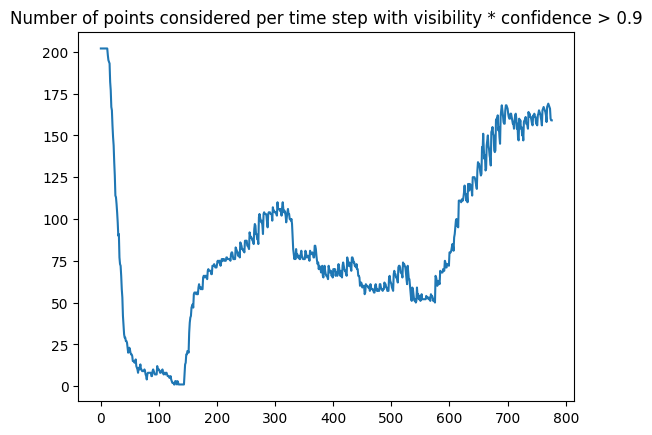

In [29]:
# How many points are being evaluated per time step?
evaluation_points.shape
plt.plot(evaluation_points.sum(axis=(0, 1)))
plt.title(f"Number of points considered per time step with visibility * confidence > {threshold}")

Text(0, 0.5, 'Value')

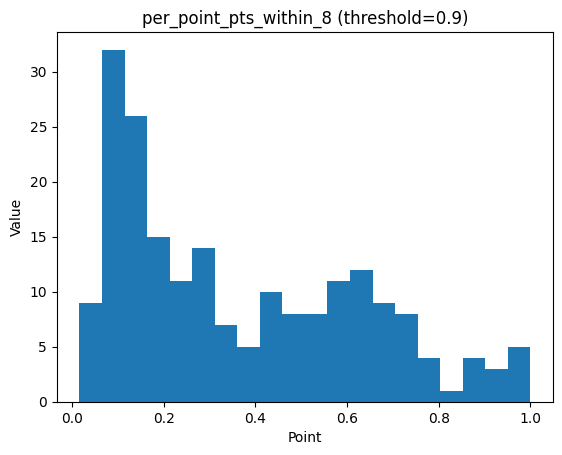

In [39]:
metric_name = 'per_point_pts_within_8'
values = metrics[metric_name][0]
# If we're doing a time metric, plot a line plot
# If we're doing a per point metric, plot distribution of values
plt.plot(values) if 'time' in metric_name else plt.hist(values, bins=20)
# Plot vertical line on self.interpolation_steps
plt.axvline(tracker.interpolation_steps, color='r', linestyle='--') if 'time' in metric_name else None
plt.title(f'{metric_name} (threshold={threshold})')
plt.xlabel('Frame' if 'time' in metric_name else 'Point')
plt.ylabel('Value')

tensor([[[-9.9998e-01, -2.2923e-04, -6.9967e-03],
         [ 6.9967e-03, -1.3254e-03, -9.9998e-01],
         [ 2.1998e-04, -1.0000e+00,  1.3270e-03]]], device='cuda:0') tensor([[-1.4122e-04,  1.8978e-05,  1.9653e-01]], device='cuda:0')


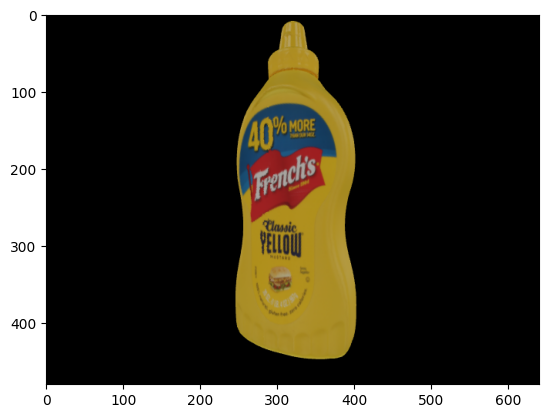

tensor([[[-9.9834e-01, -5.5441e-02,  1.5909e-02],
         [-1.5942e-02,  1.4764e-04, -9.9987e-01],
         [ 5.5432e-02, -9.9846e-01, -1.0310e-03]]], device='cuda:0') tensor([[-0.0115,  0.0030,  0.2121]], device='cuda:0')


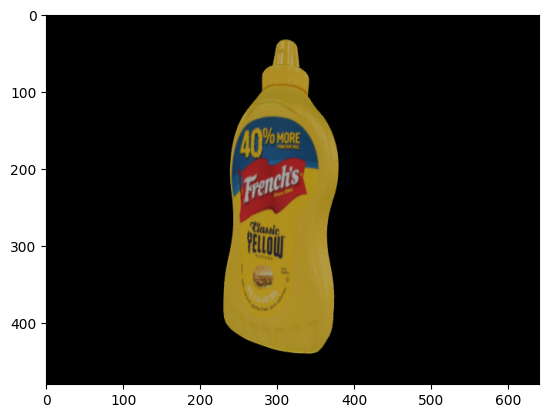

tensor([[[-0.9933, -0.1125, -0.0268],
         [ 0.0254,  0.0145, -0.9996],
         [ 0.1128, -0.9935, -0.0115]]], device='cuda:0') tensor([[-0.0242,  0.0059,  0.2278]], device='cuda:0')


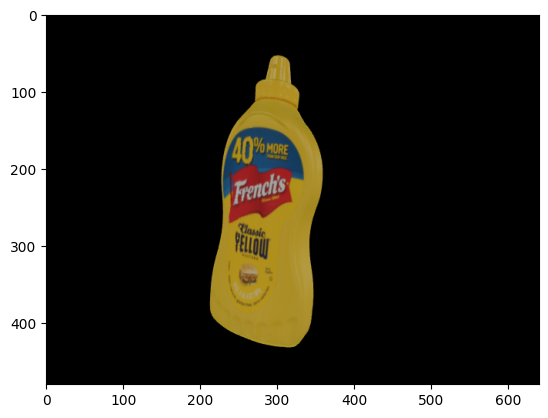

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 4.95% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))


tensor([[[-0.9860, -0.1660,  0.0180],
         [-0.0180, -0.0016, -0.9998],
         [ 0.1660, -0.9861, -0.0014]]], device='cuda:0') tensor([[-0.0352,  0.0091,  0.2442]], device='cuda:0')


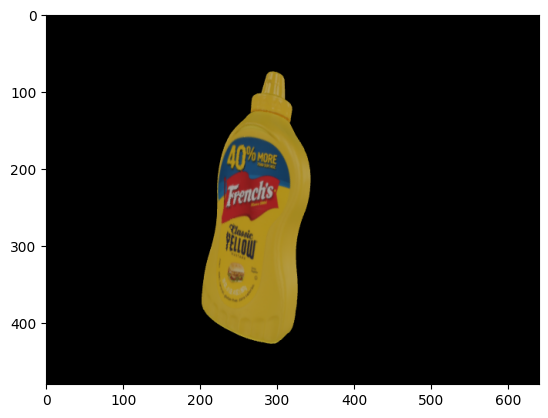

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 28.71% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))


tensor([[[-9.7445e-01, -2.2022e-01,  4.4296e-02],
         [-4.5381e-02, -1.3036e-04, -9.9897e-01],
         [ 2.1999e-01, -9.7545e-01, -9.8666e-03]]], device='cuda:0') tensor([[-0.0464,  0.0121,  0.2594]], device='cuda:0')


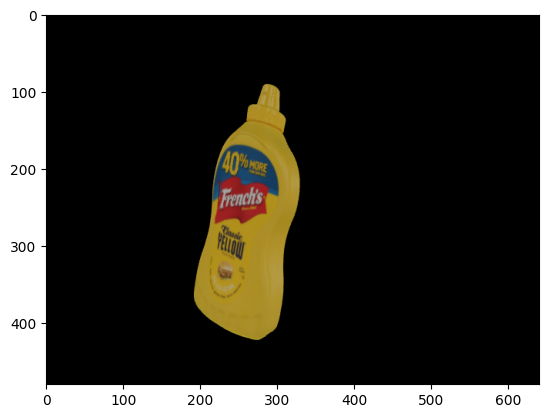

tensor([[[-0.9594, -0.2737,  0.0674],
         [-0.0694, -0.0023, -0.9976],
         [ 0.2732, -0.9618, -0.0168]]], device='cuda:0') tensor([[-0.0577,  0.0151,  0.2746]], device='cuda:0')


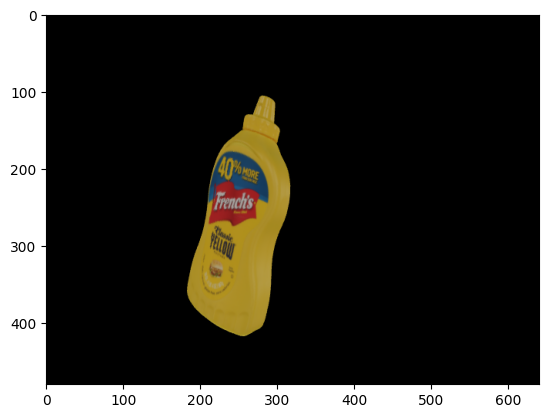

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 25.74% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))


tensor([[[-0.9416, -0.3265,  0.0828],
         [-0.0857, -0.0053, -0.9963],
         [ 0.3257, -0.9452, -0.0229]]], device='cuda:0') tensor([[-0.0692,  0.0182,  0.2902]], device='cuda:0')


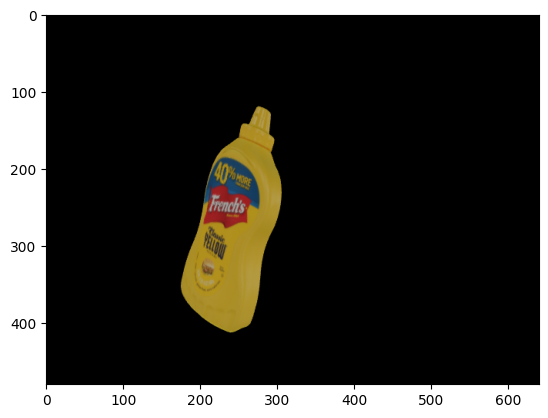

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 9.90% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))


tensor([[[-0.9201, -0.3785,  0.1005],
         [-0.1053, -0.0081, -0.9944],
         [ 0.3772, -0.9256, -0.0324]]], device='cuda:0') tensor([[-0.0805,  0.0212,  0.3054]], device='cuda:0')


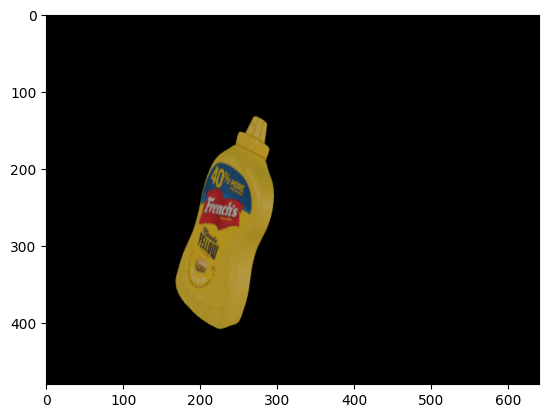

tensor([[[-0.8962, -0.4290,  0.1126],
         [-0.1186, -0.0128, -0.9929],
         [ 0.4274, -0.9032, -0.0394]]], device='cuda:0') tensor([[-0.0920,  0.0242,  0.3210]], device='cuda:0')


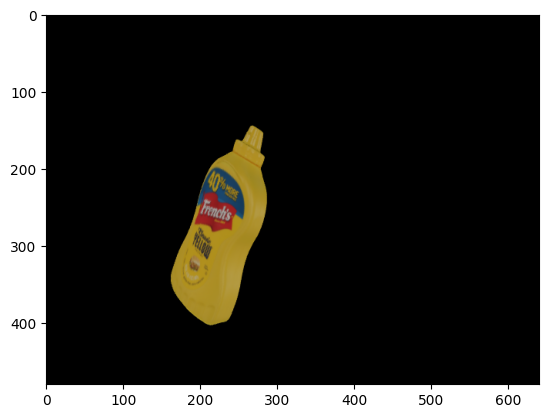

tensor([[[-0.8682, -0.4771,  0.1365],
         [-0.1428, -0.0232, -0.9895],
         [ 0.4752, -0.8785, -0.0479]]], device='cuda:0') tensor([[-0.1031,  0.0273,  0.3360]], device='cuda:0')


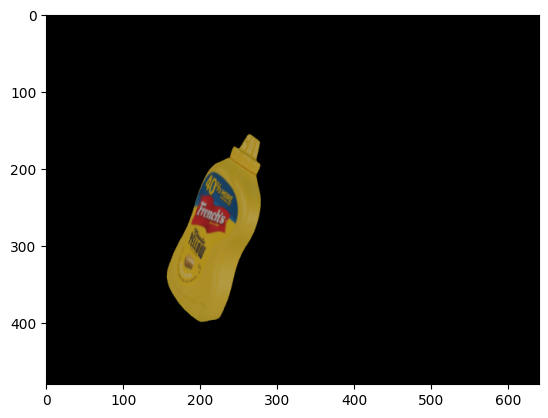

tensor([[[-0.8379, -0.5293,  0.1333],
         [-0.1498, -0.0119, -0.9886],
         [ 0.5249, -0.8483, -0.0694]]], device='cuda:0') tensor([[-0.1146,  0.0299,  0.3511]], device='cuda:0')


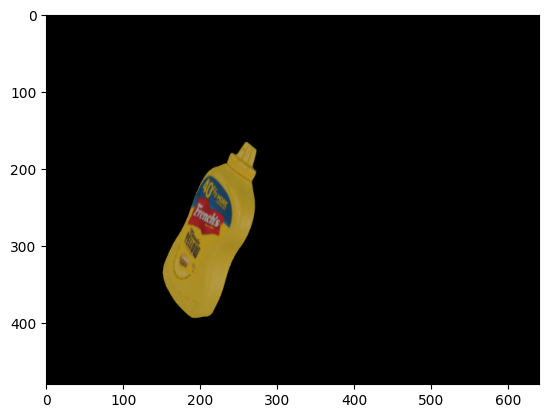

tensor([[[-0.8097, -0.5622,  0.1683],
         [-0.1611, -0.0628, -0.9849],
         [ 0.5643, -0.8246, -0.0398]]], device='cuda:0') tensor([[-0.1268,  0.0339,  0.3687]], device='cuda:0')


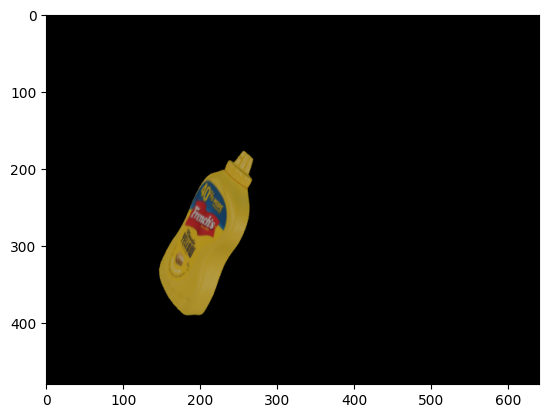

tensor([[[-0.7679, -0.6087,  0.1993],
         [-0.2012, -0.0663, -0.9773],
         [ 0.6081, -0.7906, -0.0715]]], device='cuda:0') tensor([[-0.1363,  0.0365,  0.3802]], device='cuda:0')


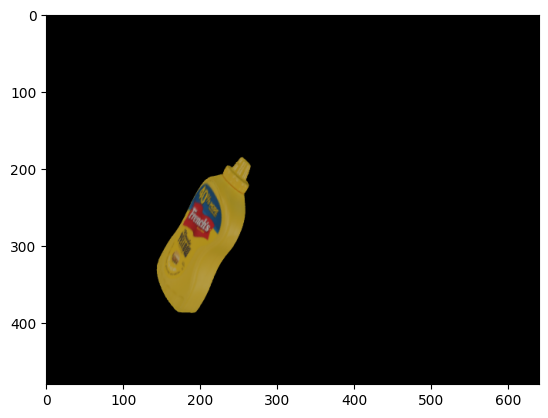

tensor([[[-0.7407, -0.6643,  0.0997],
         [-0.1286, -0.0054, -0.9917],
         [ 0.6594, -0.7474, -0.0814]]], device='cuda:0') tensor([[-0.1527,  0.0390,  0.4039]], device='cuda:0')


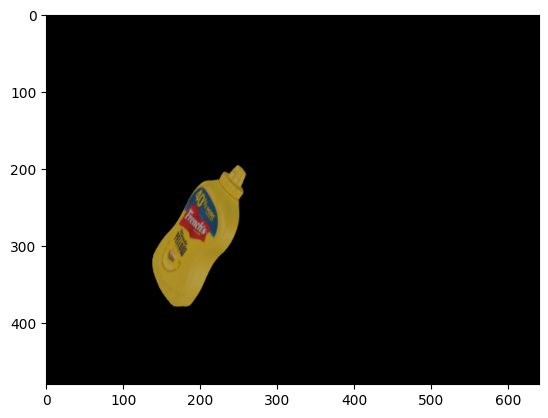

tensor([[[-0.6919, -0.6963,  0.1911],
         [-0.2074, -0.0618, -0.9763],
         [ 0.6916, -0.7151, -0.1017]]], device='cuda:0') tensor([[-0.1596,  0.0421,  0.4116]], device='cuda:0')


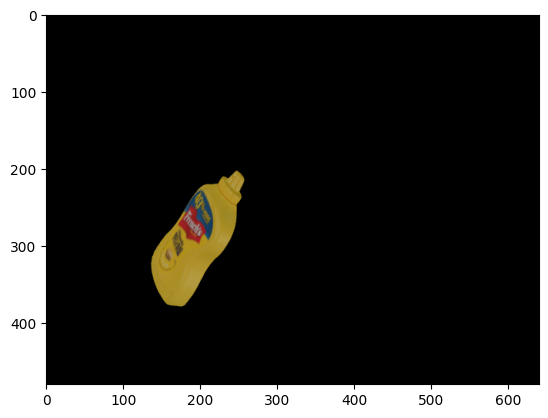

In [9]:
def solve_pnp(points_3d: torch.Tensor, points_2d: torch.Tensor, K: torch.Tensor, image_size: torch.Tensor, device: torch.device):
    if len(points_2d.shape) == 2:
        points_2d = points_2d.clone().unsqueeze(0)
    B, N, _ = points_2d.shape
    if len(points_3d.shape) == 2:
        points_3d = points_3d.clone().unsqueeze(0).repeat(B, 1, 1)
    if len(image_size.shape) == 1:
        image_size = image_size.unsqueeze(0).repeat(B, 1)
    if len(K.shape) == 2:
        K = K.clone().unsqueeze(0).repeat(B, 1, 1)
    f = torch.cat((K[:, 0, 0].unsqueeze(1), K[:, 1, 1].unsqueeze(1)), dim=1)
    p = torch.cat((K[:, 0, 2].unsqueeze(1), K[:, 1, 2].unsqueeze(1)), dim=1)
    
    camera = PerspectiveCameras(
        device=device,
        R=torch.eye(3, device=device).unsqueeze(0).repeat(B, 1, 1),
        T=torch.zeros(B, 3, device=device),
        focal_length=f,
        principal_point=p,
        in_ndc=False,
        image_size=image_size,
    )
    
    p3d = points_3d
    p2d_h = torch.cat((points_2d[..., :2], torch.ones(B, N, 1, device=device).to(device)), dim=-1)
    # Flip focal length (because of the way pytorch3d is implemented)
    K[:, 0, 0] = -K[:, 0, 0]; K[:, 1, 1] = -K[:, 1, 1]
    p_inv = torch.inverse(K)
    
        
        
    

x = (
    torch.tensor(tracker.unposed_3d_points, dtype=torch.float32)
    .to(device)
    .unsqueeze(0)
    .repeat(40, 1, 1)
)
y = pred_tracks_original.detach().clone().squeeze(0)[:40]

for i in range(15):
    pytorch_K = torch.eye(4)
    pytorch_K[:3, :3] = torch.tensor(tracker.K)
    pytorch_K = pytorch_K.to(device).float()
    f = torch.tensor([pytorch_K[0, 0], pytorch_K[1, 1]]).to(device).unsqueeze(0)
    p = torch.tensor([pytorch_K[0, 2], pytorch_K[1, 2]]).to(device).unsqueeze(0)
    camera = PerspectiveCameras(
        device=device,
        R=torch.eye(3).unsqueeze(0),
        T=torch.tensor([0, 0, 0.0]).unsqueeze(0),
        # K=pytorch_K.unsqueeze(0),
        focal_length=f,
        principal_point=p,
        in_ndc=False,
        image_size=torch.tensor((tracker.H, tracker.W)).to(device).unsqueeze(0),
    )
    gt_pose = torch.tensor(tracker.get_gt_pose(i)).float().to(device)
    posed_points = apply_pose_to_points(x[i], gt_pose[:3, :3], gt_pose[:3, 3])
    # rendered_points = render_points_in_2d(posed_points, pytorch_K[:3, :3]).unsqueeze(0)
    rendered_points = camera.transform_points_screen(posed_points.unsqueeze(0))
    num_batch = rendered_points.shape[0]
    num_pts = rendered_points.shape[1]

    p3d = posed_points
    p2d_h = torch.cat(
        (rendered_points[..., :2], torch.ones(num_batch, num_pts, 1).to(device)), dim=-1
    )
    pytorch_K[0, 0] = -pytorch_K[0, 0]
    pytorch_K[1, 1] = -pytorch_K[1, 1]
    p_inv = torch.inverse(pytorch_K[:3, :3]).T
    p2d_uncal = torch.matmul(p2d_h, p_inv.unsqueeze(0))
    transform = efficient_pnp(x[i].unsqueeze(0), p2d_uncal[..., :2])

    print(transform.R, transform.T)

    gt_pose = torch.eye(4).to(device)
    gt_pose[:3, :3] = transform.R.squeeze().T
    gt_pose[:3, 3] = transform.T.squeeze()
    rgb, _ = tracker.dataset.render_mesh_at_pose(gt_pose.detach().cpu().numpy())
    rgb_gt, _ = tracker.dataset.render_mesh_at_pose(gt_pose.detach().cpu().numpy())
    rgb_avg = cv2.addWeighted(rgb, 0.5, rgb_gt, 0.5, 0)
    plt.imshow(rgb_avg)
    # plt.imshow(rgb)
    plt.show()